In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from google.cloud import storage
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 64

### Regex for extracting labels : \S+(?=_)

<pre>
\S : any non-whitespace character <br>
\+  : Matches between one and unlimited times, as many times as possible, giving back as needed (greedy) <br>
\(?=_)  : Positive Lookahead <br>
    _ : matches the character _ literally (case sensitive) <br>
</pre>

In [4]:
np.random.seed(2)
pat = r'([^/]+)(?=_)'

In [5]:
fnames = list(filter(lambda x: x!=".DS_Store" , get_image_files("data/images")))
fnames[:5]

[PosixPath('data/images/no-finding_00028666-002.png'),
 PosixPath('data/images/no-finding_00025622-000.png'),
 PosixPath('data/images/no-finding_00025680-008.png'),
 PosixPath('data/images/no-finding_00012060-000.png'),
 PosixPath('data/images/no-finding_NORMAL2-IM-0364-0001.jpeg')]

In [6]:
data = ImageDataBunch.from_name_re('data/images', fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

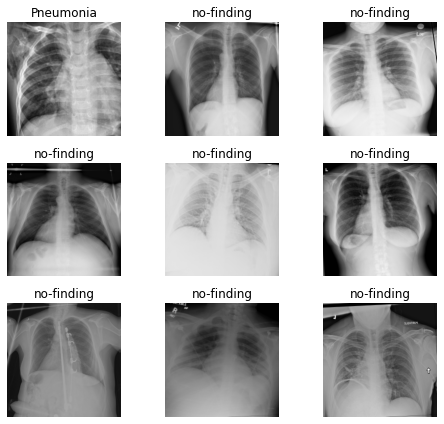

In [7]:
data.show_batch(rows=3, figsize=(7,6))

In [8]:
print(data.classes)
len(data.classes),data.c

['COVID-19', 'Pneumonia', 'no-finding']


(3, 3)

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [10]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.159753,0.100453,0.018997,07:49
1,0.111038,0.085139,0.018649,05:19
2,0.098307,0.077933,0.018070,05:20
3,0.080927,0.073514,0.016564,05:21


In [16]:
learn.save('stage-1')

### Results

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

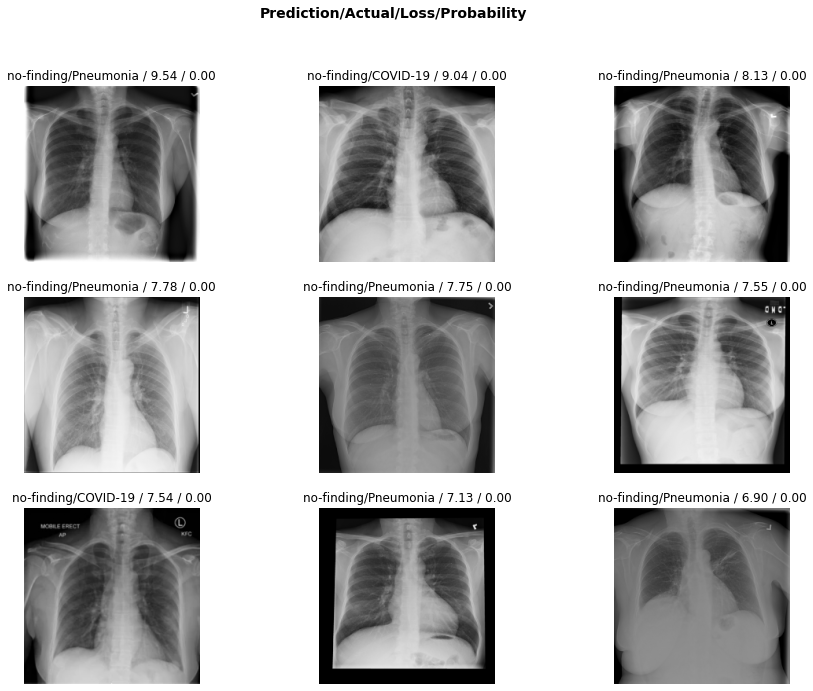

In [13]:
interp.plot_top_losses(9, figsize=(15,11))

In [14]:
doc(interp.plot_top_losses)

_cl_int_plot_top_losses [source] [test] _cl_int_plot_top_losses ( k , largest = True , figsize = (12, 12) , heatmap : bool = False , heatmap_thresh : int = 16 , alpha : float = 0.6 , cmap : str = 'magma' , show_text : bool = True , return_fig : bool = None ) → Optional [ Figure ] 
 
 × No tests found for _cl_int_plot_top_losses . To contribute a test please refer to this guide and this discussion . Show images in top_losses along with their prediction, actual, loss, and probability of actual class. 
 Show in docs

In [15]:
interp.most_confused(min_val=2)

[('Pneumonia', 'no-finding', 112),
 ('COVID-19', 'no-finding', 18),
 ('no-finding', 'Pneumonia', 11),
 ('no-finding', 'COVID-19', 2)]

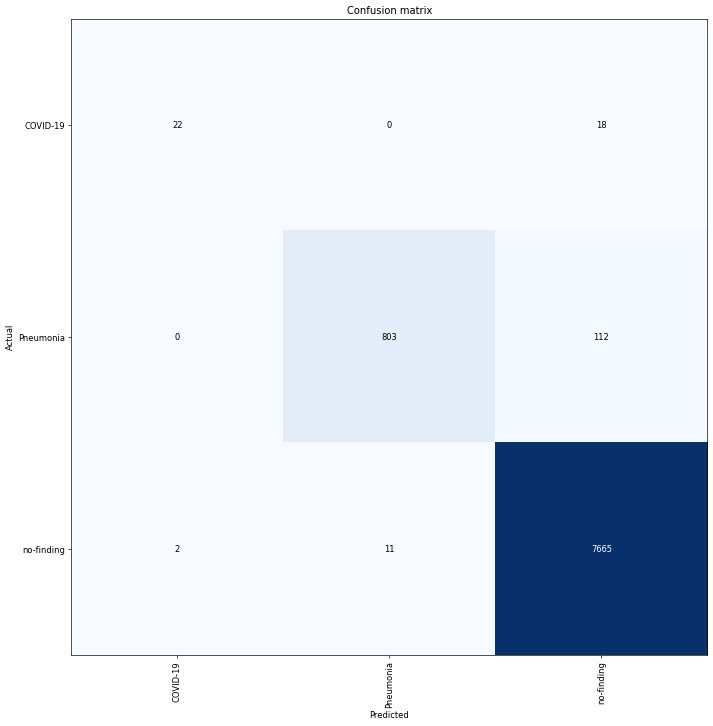

In [17]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Unfreezing, fine-tuning, and learning rates

In [18]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.078845,0.068964,0.015638,05:20


In [20]:
learn.load('stage-1');

In [21]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


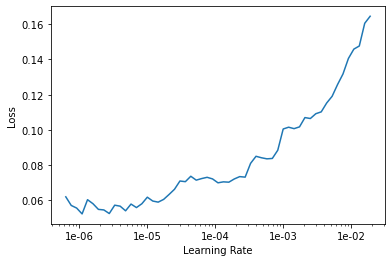

In [22]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.072544,0.070153,0.015406,05:18
